## *Jeu de données IRVE*
-------------------
# Indicateurs d'intégrité des données IRVE
     
### Présentation
Ce document identifie les points de recharge du jeu de données IRVE présentant des problèmes d'intégrité (*ex. une station associée à plusieurs coordonnées différentes, une coordonnée associée à plusieurs adresses*).   
    
Il complète l'analyse des données présentée dans [une note spécifique](http://nbviewer.org/github/loco-philippe/Environmental-Sensing/tree/main/python/Validation/irve/Analyse/IRVE_v3.ipynb).
     
### Sommaire
*(liens actifs sur jupyter Notebook ou [Nbviewer](http://nbviewer.org/github/loco-philippe/Environmental-Sensing/tree/main/python/Validation/irve/Analyse/IRVE_indicateurs.ipynb))*
- [Evolution des données](#Evolution-des-données)
- [Evolution des données (hors doublons)](#Evolution-des-données-(hors-doublons))
- [Défaut d'intégrité](#Défaut-d\'intégrité)
- [Localisation des stations comportant un écart](#Localisation-des-stations-comportant-un-écart)
- [Principaux écarts](#Principaux-écarts)
- [Annexe - Fonctions utilisées](#Annexe---Fonctions-utilisées)

### Fichiers de données
Plusieurs fichiers liés aux défauts d'intégrité sont disponibles [ici](https://github.com/loco-philippe/Environmental-Sensing/blob/main/python/Validation/irve/Analyse/README.md#5---Documentation):
- fichier csv des lignes résiduelles à traiter (IRVE_itinerance_residuel)
- fichier csv des données itinerance avec indicateur des données à corriger ou à ignorer (IRVE_itinerance_complet)
- fichier csv des données itinerance valides (IRVE_itinerance_valide)
- fichier csv des doublons (IRVE_itinerance_doublons)

In [17]:
indic = indicateurs(chemin)

## Evolution des doublons
Le graphe ci-dessous présente l'évolution du nombre de points de recharge documentés dans le jeu de données avec une distinction entre les données présentant ou non des doublons (doublon : plusieurs point de recharge avec le même identifiant).      
       
Le nombre de doublons était très important avant l'été 2023 (plus de 40%). Les travaux menés pendant l'été ont permis de ramener le nombre de doulons à 5%.

On note néanmoins une remontée depuis la fin 2023 qui a été réduite mais reste encore significative (10 %).

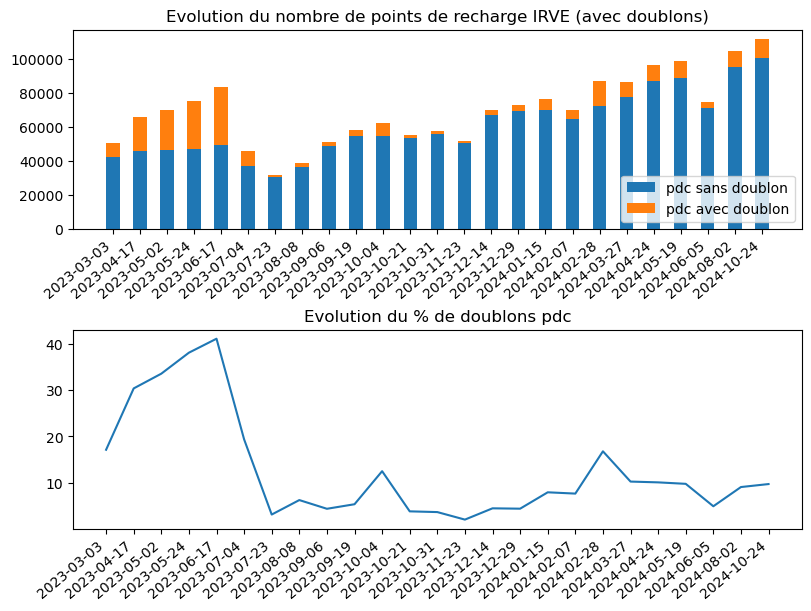

In [18]:
doublons(indic)

## Evolution des données (hors doublons)
Le graphe ci-dessous présente l'évolution du nombre de points de recharge documentés dans le jeu de données avec une distinction entre les données présentant ou non des défauts d'intégrité.      

Le nombre de points de recharge est passé de 40 000 en début d'année 2023 à 95 000 début Août 2024 malgré une diminution pendant l'été 2023 (passage de 45 000 à moins de 30 000) résorbée ensuite.
On observe depuis fin novembre 2023 une augmentation régulière du nombre de point de recharge (2 000 par mois).

Il est à noter que malgré la structure complexe du jeu de données IRVE, le taux de défaut a pu rester majoritairement à un niveau faible ( < 4 % ). 
Le mauvais niveau de qualité des données ajoutées après l'été a dégradé le niveau de qualité (le taux de défaut a atteint 15% en septembre).
Une évolution apportée en avril 2024 a également conduit à un doublement du nombre de défauts. 
Ces difficultés ont pu être traitées dans les semaines qui ont suivi.

Le nombre de défauts pourrait être divisé par deux en traitant les cinq écarts présentés dans la suite de ce Notebook.

Nota :
- les défauts signalés concernant l'Eure ont été traités
- les défauts signalés concernant e-vadea ont été traités
- les défauts signalés concernant Ouest-charge ont été traités
- les défauts signalés concernant Freshmile ont été traités
- les défauts signalés concernant Power Dot ont été traités
- les défauts signalés concernant Ouestcharge-Paysdelaloire ont été traités

pdc valide :  97526
pdc defaut :  3365


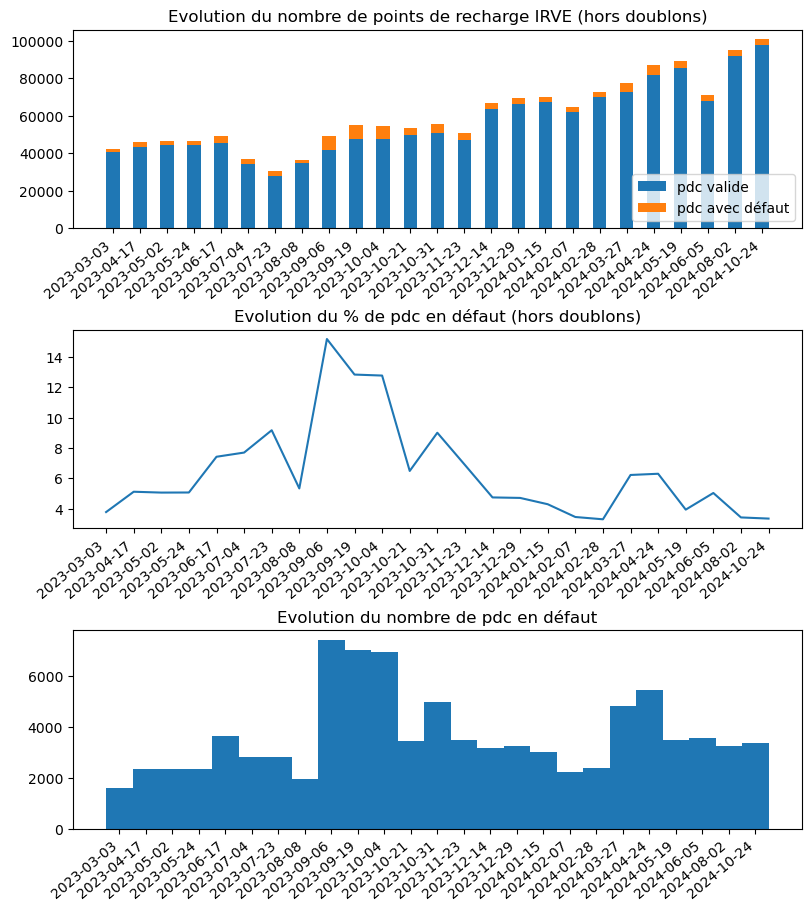

In [19]:
evolution(indic)

## Défaut d'intégrité
Les défauts d'intégrité découlent du [modèle de données](http://nbviewer.org/github/loco-philippe/Environmental-Sensing/tree/main/python/Validation/irve/Analyse/IRVE_modele.ipynb) associé au jeu de données : 
- défauts liés aux relations entre entités :
    - Un pdc est unique et associé à une ligne du jeu de données
    - Un pdc est intégré dans une et une seule station
    - Une station est opérée par un et un seul opérateur
    - Une station est hébergée par une et une seule enseigne
    - Une station a une et une seule localisation
- défauts liés entre un attribut et une entité :
    - Une station a un et un seul “nom_station”
    - Une station a une et une seule “implantation_station”
    - Une station a un et un seul “nbre_pdc”
    - Une station a un et un seule “condition_accès”
    - Une station a un et un seul “horaires”
    - Une station a un et un seul “station_deux_roues”
    - Une localisation correspond à une et une seule “adresse_station”

La majorité des défauts d'intégrité (51 %) est lié à la documentation d'adresses différentes pour des coordonnées identiques.

Ceci est lié à des erreurs de saisie mais également lorsque plusieurs stations partagent les mêmes coordonnées mais que les adresses de ces stations ne sont pas identiques.

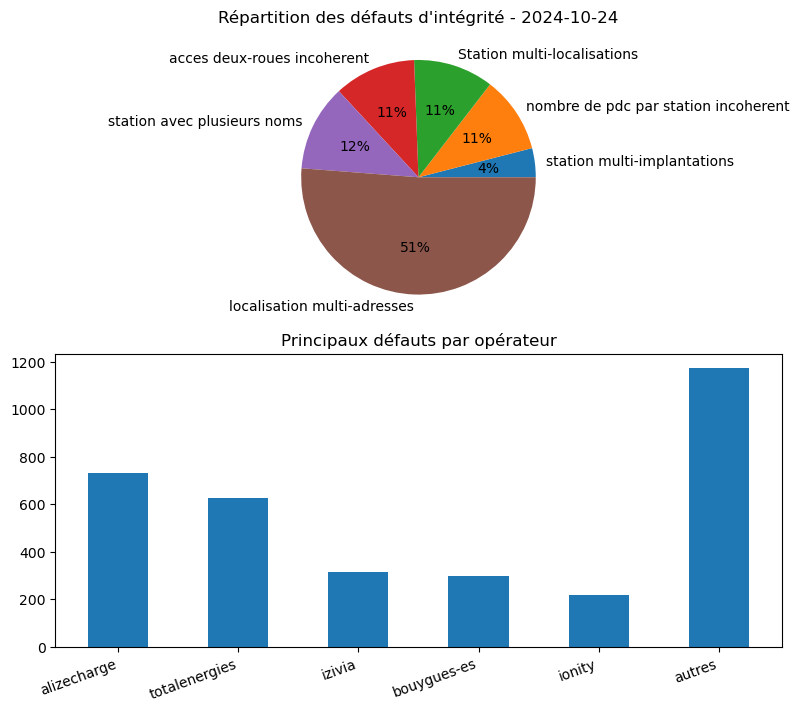

In [20]:
date = defaut_integrite(indic)

## Localisation des stations comportant un écart

La représentation cartographique permet de localiser les principales zones géographiques des défauts identifiés. Deux régions regroupent un nombre de défauts important :

- la région parisienne,
- la région Bretagne

### icones de la carte
icones rouge : stations avec un écart de relations entre entités (voir introduction)     
icones orange : stations avec un défaut d'attributs (voir introduction)     

### indicateurs de défauts
Les libellés en fin de fenêtres contextuelles "champ 1 - champ 2 : False" signifient que 
le champ 2 est associé à plusieurs champ 1 en fonction des pdc (défaut d'intégrité).       
       
*Par exemple : "coordonneesXY - id_station_itinerance : False" signifie qu'il existe plusieurs pdc 
avec une même la valeur du champ "id_station_itinerance" mais plusieurs valeurs du champ "coordonnéesXY".*
   
**Nota :** 
- La carte est également accessible et partageable (fichier 'irve.html' présent sur le repository)
- les libellés de défaut sont identiques à ceux du fichier des écarts.


In [21]:
defaut_carte(date, chemin).show('irve.html')

##### Principaux écarts
Sur les 3 365 points de charge en défaut, 1 300 défauts pourraient être éliminés en traitant les 5 points ci-dessous.

### Stations AlizeCharge

Les défauts identifiés concernent des stations regroupées sous un même identifiant ou sous une même localisation (200 points de recharge). 

Par exemple, les stations ADP 'FRADPE9 1479018xx' situées aux coordonnées [2.362554,48.728787] regroupent 80 points de recharge mais avec plusieurs adresses ou plusieurs noms de station (erreur de saisie) ou bien un nombre de points de rechage variable ou encore une implantation (voirie / parking public) variable.

Les défauts liés aux transferts de stations entre Bouygues et AlizeCharge (ex stations Ecocharge77 déclarées à la fois chez Bouygues et chez AlizeCharge) s'ajoutent également à ce défaut.

### Stations TotalEnergie
450 points de charge TotalEnergie ont une documentation incohérente du champ "station_deux_roues" (voir [l'analyse des données](http://nbviewer.org/github/loco-philippe/Environmental-Sensing/tree/main/python/Validation/irve/Analyse/IRVE_v3.ipynb#Repartition-des-defauts-par-operateur)). Ceci concerne essentiellement les stations Belib de Paris (voir carte).

### Stations Izivia
Les défauts au nombre de 320 sont liés à une incohérence entre adresse et coordonnées (une même coordonnée a plusieurs adresses différentes). Ce défaut est lié soit à des erreurs de saisie, soit à des ajouts (ou remplacements) ultérieurs de stations à une même localisation.

Les stations Izivia en erreur ont un id_station_itinerance identique à l'id_pdc_itinerance, ce qui se traduit par des adresses multiples pour une même coordonnée (voir exemple dans [l'analyse des données](http://nbviewer.org/github/loco-philippe/Environmental-Sensing/tree/main/python/Validation/irve/Analyse/IRVE_v3.ipynb#Defauts-operateur-IZIVIA)).

Par exemple, sur un parking [-0.530598, 47.398424], on trouve 17 stations avec la même coordonnée, le même identifiant entre point de recharge et station et un nombre de PdC indiqué entre 1 et 3.

### Stations Bouygues

Les défauts (300 points de recharge) sont liés à une incohérence entre adresse et coordonnées (une même coordonnée a plusieurs adresses différentes).

Les défauts sont majoritairement associés à l'enseigne Ecocharge77 pour laquelle on trouve des stations en doublon entre Bouygues et AlizeCharge. Ce défaut semble être lié à un transfert de bornes d'un opérateur à un autre sans que les anciennes stations aient été supprimées.

Par exemple, pour la coordonnées [3.438183,48.694653], on trouve quatre points de recharge associés à deux stations (une est opérée par Bouygues et l'autre par AlizeCharge).

La solution est donc de supprimer les pdc associés à l'ancien opérateur.

### Stations Ionity
Les défauts (220 points de recharge) sont liés à une incohérence entre adresse et coordonnées (une même coordonnée est associée à plusieurs adresses différentes). Ce défaut est lié principalement à des adresses de station différentes pour des coordonnées identiques. 

Par exemple, pour les coordonnées [1.580008, 48.468782], on trouve deux stations avec des adresses différentes :
- 'Aire de Chartres-Gasville, A11 - 28300 Gasville-Oiséme'
- 'Chartres-Gasville A11, 28300 Gasville-Oisème'

 La solution est donc de vérifier les adresses documentées lorsque plusieurs stations sont localisées avec des coordonnées identiques.

## Annexe - Fonctions utilisées

In [22]:
import json
import ntv_pandas as npd
import pathlib

chemin = str(pathlib.Path(npd.__file__).parent.parent.parent/"Environmental-Sensing"/"python"/"Validation"/"irve"/"Analyse")

def indicateurs(chemin):
    dic = {}
    with open(chemin + '/' + 'logfile.txt', 'r', encoding="utf-8") as f:
        for line in f:
            if len(line) > 3:
                log = json.loads(line)
                dic[log['date_irve']] = log
    return list(tuple(zip(*sorted(zip(list(dic.keys()),dic.values()))))[1])

In [23]:
import matplotlib.pyplot as plt

def defaut_integrite(indic):
    '''génération d'un graphe présentant la répartition des défauts d'intégrité''' 
    seuil = 1 # les valeurs inférieures à ce pourcentage ne sont pas prises
    defauts = ['Pdc non unique', 'Station multi-operateurs', 'Station multi-enseignes', 'Station multi-localisations', 
               'Pdc multi-stations', 'station avec plusieurs noms', 'station multi-implantations', 
               'nombre de pdc par station incoherent', 'station multi-acces', 'station multi-horaires', 
               'acces deux-roues incoherent', 'localisation multi-adresses']
    val = dict(item for item in indic[-1].items() if item[0] in defauts and item[1] > 0)
    val = dict(sorted(val.items(), key=lambda item:item[1], reverse=False))
    date = indic[-1]['date_irve']
    total = indic[-1]['IRVE_itinerance_residuel' + date + '.csv']
    operateurs = [oper.split(sep='@')[1].split('.')[0] for oper in indic[-1]['operateurs']] + ['autres']
    defauts = indic[-1]['erreurs_operateurs'] + [total - sum(indic[-1]['erreurs_operateurs'])]
    mini = min(list(val.values()).index(value) for value in val.values() if value / sum(val.values()) *100 > seuil)

    fig, (ax, ax2) = plt.subplots(2, 1, layout='constrained', figsize=(8, 7))
    ax.pie(list(val.values())[mini:], autopct='%.0f%%', labels=list(val.keys())[mini:])
    ax.set_title("Répartition des défauts d'intégrité - " + date)
    ax2.bar(operateurs, defauts, width=0.5)
    plt.setp(ax2.get_xticklabels(), rotation=20, ha="right")
    ax2.set_title("Principaux défauts par opérateur")
    plt.show()
    return date

In [24]:
def doublons(log):
    '''génération d'un graphe présentant l'évolution du nombre de doublons pdc + stations'''
    
    dic = {}
    for i, indic in enumerate(log):
        if i == 0:
            dic['date'] = []
            dic['pdc doublon'] = []
            dic['pdc sans doublon'] = []
            dic['pdc doublon %'] = []
        else:
            date = indic['date_irve']
            dic['date'].append(date)
            doublon = indic['IRVE_itinerance_doublons' + date + '.csv']
            dic['pdc doublon'].append(doublon)
            dic['pdc sans doublon'].append(indic['IRVE_itinerance_complet'   + date + '.csv'] - doublon)
            dic['pdc doublon %'].append(100 * dic['pdc doublon'][-1] / (dic['pdc doublon'][-1] + dic['pdc sans doublon'][-1]))
    fig, (ax2, ax1) = plt.subplots(2, 1, layout='constrained', figsize=(8, 6))
    ax1.plot(dic['date'], dic['pdc doublon %'])
    ax1.set_title('Evolution du % de doublons pdc')
    plt.setp(ax1.get_xticklabels(), rotation=40, ha="right")
    bottom = [0] * (len(log) - 1)
    ax2.bar(dic['date'], dic['pdc sans doublon'], width=0.5, label='pdc sans doublon', bottom=[0] * (len(log) - 1))
    ax2.bar(dic['date'], dic['pdc doublon'], width=0.5, label='pdc avec doublon', bottom=dic['pdc sans doublon'])
    ax2.set_title("Evolution du nombre de points de recharge IRVE (avec doublons)")
    plt.setp(ax2.get_xticklabels(), rotation=40, ha="right")
    ax2.legend(loc="lower right")
    plt.show()

In [25]:
import pandas as pd

def evolution(log):
    '''génération d'un graphe présentant l'évolution du nombre de pdc valides ou présentant des défauts'''
    
    dic = {}
    for i, indic in enumerate(log):
        if i == 0:
            dic['date'] = []
            dic['pdc defaut'] = []
            dic['pdc valide'] = []
            dic['pdc defaut %'] = []
            dic['pdc'] = []
        else:
            date = indic['date_irve']
            dic['date'].append(date)
            dic['pdc defaut'].append(indic['IRVE_itinerance_residuel' + date + '.csv'])
            dic['pdc valide'].append(indic['IRVE_itinerance_valide'   + date + '.csv'])
            dic['pdc defaut %'].append(100 * dic['pdc defaut'][-1] / (dic['pdc defaut'][-1] + dic['pdc valide'][-1]))
            dic['pdc'].append(dic['pdc defaut'][-1] + dic['pdc valide'][-1])
    pd.DataFrame(dic).to_csv('evolution.csv')
    print('pdc valide : ', dic['pdc valide'][-1])
    print('pdc defaut : ', dic['pdc defaut'][-1])
    fig, (ax2, ax1, ax3) = plt.subplots(3, 1, layout='constrained', figsize=(8, 9))
    ax1.plot(dic['date'], dic['pdc defaut %'])
    ax1.set_title('Evolution du % de pdc en défaut (hors doublons)')
    plt.setp(ax1.get_xticklabels(), rotation=40, ha="right")
    
    ax3.bar(dic['date'], dic['pdc defaut'], width=1, label='pdc defaut', bottom=[0] * (len(log) - 1))
    ax3.set_title('Evolution du nombre de pdc en défaut')
    plt.setp(ax3.get_xticklabels(), rotation=40, ha="right")
    
    bottom = [0] * (len(log) - 1)
    ax2.bar(dic['date'], dic['pdc valide'], width=0.5, label='pdc valide', bottom=[0] * (len(log) - 1))
    ax2.bar(dic['date'], dic['pdc defaut'], width=0.5, label='pdc avec défaut', bottom=dic['pdc valide'])
    ax2.set_title("Evolution du nombre de points de recharge IRVE (hors doublons)")
    plt.setp(ax2.get_xticklabels(), rotation=40, ha="right")
    ax2.legend(loc="lower right")
    plt.show()

In [26]:
import pandas as pd
from util_carto import Cart

def defaut_carte(date, chemin):
    '''génération d'une carte folium des stations présentant des défauts d'intégrité'''
    
    file = 'IRVE_itinerance_residuel'+date+'.csv'
    #chemin = 'https://raw.githubusercontent.com/loco-philippe/Environmental-Sensing/main/python/Validation/irve/Analyse/'
    #chemin = 'D:\\philippe\\python ESstandard\\Environmental-Sensing\\python\\Validation\\irve\\Analyse\\'
    #chemin = 'C:\\Users\\phili\\github\\Environmental-Sensing\\python\\Validation\\irve\\Analyse\\'
    irve = pd.read_csv(chemin + '/' + file, sep=',', low_memory=False)
    
    principal = [17, 18, 19, 20, 21]
    irve['principal'] = True
    for ind in principal:
        irve['principal'] &= irve.iloc[:,ind]
    irve_p = irve[~irve['principal']].drop_duplicates('id_station_itinerance').reset_index(drop=True)
    
    secondaire = [22, 23, 24, 25, 26, 27, 28]
    irve['secondaire'] = True
    for ind in secondaire:
        irve['secondaire'] &= irve.iloc[:,ind]
    irve['secondaire'] |= (~irve['principal'] & ~irve['secondaire'])
    irve_s = irve[~irve['secondaire']].drop_duplicates('id_station_itinerance').reset_index(drop=True)
    
    popup = [[], []]
    locat = [[], []]
    vide = {'  ': '  '}
    for ind, irve in enumerate((irve_p, irve_s)):
        for i in range(len(irve)):
            defauts = {irve_p.columns[col]: False  for col in range(17, 29) if not irve.iloc[i,col]}
            popup[ind].append( {'id_station': irve['id_station_itinerance'][i], 
                               'id_pdc': irve['id_pdc_itinerance'][i],
                               'contact_operateur': irve['contact_operateur'][i],
                               'nom_enseigne': irve['nom_enseigne'][i],
                               'nom_station': irve['nom_station'][i],
                               'adresse_station': irve['adresse_station'][i],
                               'fichier des écarts': '<a href="https://github.com/loco-philippe/Environmental-Sensing/blob/main/python/Validation/irve/Analyse/">IRVE_itinerance_residuel</a>',
                               'date du fichier': date } | vide | defauts )
            coord = json.loads(irve['coordonneesXY'][i])
            coord.reverse()
            locat[ind].append(coord)

    cart = Cart([47, 2.5], zoom_start=6)
    cart.add_markers(locat[0], popup=popup[0], color='red', group='écarts entités', max_width=250)
    cart.add_markers(locat[1], popup=popup[1], color='orange', group='écarts attributs', max_width=250, icon='bug')
    return cart